In [315]:
import numpy as np
import matplotlib.pyplot as plt

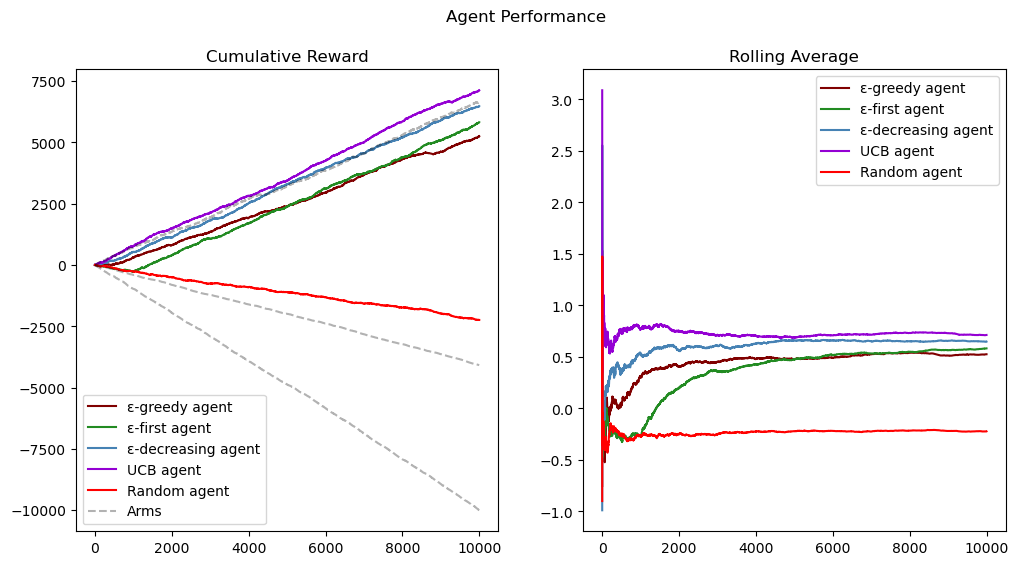

In [436]:
np.random.seed(1)

k = 3
N = 10000
epsilon = 0.1

# K-armed stochastic bandit envirnment
bandits = []
for i in range(k):
    a = np.random.uniform(-1, 3)
    b = np.random.uniform(0.5, 3)
    bandits.append((a,b))

def get_reward(arm):
        a, b = bandits[arm]
        return np.random.normal(a,b)

#-------------#
# Random agent
#-------------#

arm1_scores = [0]
arm2_scores = [0]
arm3_scores = [0]

for i in range(N):
    arm1_scores.append(get_reward(0) + arm1_scores[-1])
    arm2_scores.append(get_reward(1) + arm2_scores[-1])
    arm3_scores.append(get_reward(2) + arm3_scores[-1])

random_arm = [0]
random_rewards = []

for i in range(N):
    arm = np.random.randint(0, k)
    reward = get_reward(arm)
    random_rewards.append(reward)
    random_arm.append(reward + random_arm[-1])

#---------------#
# ε-first agent
#---------------#

epsilon_first = [0]
arm_history = {arm_index: [] for arm_index in range(len(bandits))}
first_rewards = []

for i in range(N):
    if i < (epsilon * N):
        arm = np.random.randint(0, k)
        reward = get_reward(arm)
        arm_history[arm].append(reward)
    else:
        curr_best_EV = 0
        curr_best_arm = 0
        for arm in range(k):
            EV = np.mean(arm_history[arm])
            if EV > curr_best_EV:
                curr_best_EV = EV
                curr_best_arm = arm
        reward = get_reward(curr_best_arm)
    first_rewards.append(reward)
    epsilon_first.append(reward + epsilon_first[-1])

#----------------#
# ε-greedy agent
#----------------#

epsilon_greedy = [0]
greedy_arm_history = {arm_index: [] for arm_index in range(len(bandits))}
greedy_rewards = []

for i in range(N):
    p = np.random.random()
    if p < epsilon:
        arm = np.random.randint(0,k)
        reward = get_reward(arm)
    else:
        curr_best_EV = 0
        curr_best_arm = 0
        for arm in range(k):
            if greedy_arm_history[arm]:
                EV = np.mean(greedy_arm_history[arm])
            else:
                EV = 0
            if EV > curr_best_EV:
                curr_best_EV = EV
                curr_best_arm = arm
        reward = get_reward(curr_best_arm)
    greedy_rewards.append(reward)
    greedy_arm_history[arm].append(reward)
    epsilon_greedy.append(reward + epsilon_greedy[-1])
    
#--------------------#
# ε-decreasing agent
#--------------------#

epsilon_decreasing = [0]
decreasing_arm_history = {arm_index: [] for arm_index in range(len(bandits))}
decreasing_rewards = []

epsilon_start = 1.0
epsilon_min = 0.01
decay_rate = 0.99

for i in range(N):
    epsilon = max(epsilon_min, epsilon_start * (decay_rate**i))
    p = np.random.random()
    if p < epsilon:
        arm = np.random.randint(0,k)
        reward = get_reward(arm)
    else:
        curr_best_EV = 0
        curr_best_arm = 0
        for arm in range(k):
            if decreasing_arm_history[arm]:
                EV = np.mean(decreasing_arm_history[arm])
            else:
                EV = 0
            if EV > curr_best_EV:
                curr_best_EV = EV
                curr_best_arm = arm
        reward = get_reward(curr_best_arm)
    decreasing_rewards.append(reward)
    decreasing_arm_history[arm].append(reward)
    epsilon_decreasing.append(reward + epsilon_decreasing[-1])

#------------------------------------#
# UCB (upper confidence bound) agent
#------------------------------------#

arm_counts = [0 for i in range(k)]
arm_EV = [0 for i in range(k)]
UCB = [0]
UCB_rewards = []

for i in range(N):
    ucb_values = []
    for arm in range(k):
        if arm_counts[arm] > 0:
            EV = arm_EV[arm]
            confidence = np.sqrt(2 * np.log(i)) / arm_counts[arm]
            ucb_value = EV + confidence
        else:
            ucb_value = np.inf
        ucb_values.append(ucb_value)
    chosen_arm = np.argmax(ucb_values)
    reward = get_reward(chosen_arm)
    UCB_rewards.append(reward)
    UCB.append(reward + UCB[-1])
    arm_counts[chosen_arm] += 1
    arm_EV[chosen_arm] = ((arm_counts[chosen_arm] - 1) * arm_EV[chosen_arm] + reward) / arm_counts[chosen_arm]

#-------------------------------#
# Evaluating agent performances
#-------------------------------#

first_rolling_avg = []
greedy_rolling_avg = []
random_rolling_avg = []
UCB_rolling_avg = []
decreasing_rolling_avg = []

for i in range(N):
    first_rolling_avg.append(np.mean(first_rewards[:i+1]))
    greedy_rolling_avg.append(np.mean(greedy_rewards[:i+1]))
    random_rolling_avg.append(np.mean(random_rewards[:i+1]))
    UCB_rolling_avg.append(np.mean(UCB_rewards[:i+1]))
    decreasing_rolling_avg.append(np.mean(decreasing_rewards[:i+1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(epsilon_greedy, c="maroon", label="ε-greedy agent")
axs[0].plot(epsilon_first, c="forestgreen", label="ε-first agent")
axs[0].plot(epsilon_decreasing, c="steelblue", label="ε-decreasing agent")
axs[0].plot(UCB, c="darkviolet", label="UCB agent")
axs[0].plot(random_arm, c="red", label="Random agent")
axs[0].plot(arm1_scores, c="black", alpha=0.3, linestyle="dashed", label="Arms")
axs[0].plot(arm2_scores, c="black", alpha=0.3, linestyle="dashed")
axs[0].plot(arm3_scores, c="black", alpha=0.3, linestyle="dashed")
axs[0].set_title("Cumulative Reward")
axs[0].legend() 
axs[1].plot(greedy_rolling_avg, c="maroon", label="ε-greedy agent")
axs[1].plot(first_rolling_avg, c="forestgreen", label="ε-first agent")
axs[1].plot(decreasing_rolling_avg, c="steelblue", label="ε-decreasing agent")
axs[1].plot(UCB_rolling_avg, c="darkviolet", label="UCB agent")
axs[1].plot(random_rolling_avg, c="red", label="Random agent")
axs[1].legend()
axs[1].set_title("Rolling Average")
plt.suptitle("Agent Performance")
plt.show()